##### Code for Trolley et al. CDOM merge paper

Goal of this notebook:
- construct dataframe of paired cary-100/ultrapath cdom measurements from provides seabass files
- compute different merges for the paired measurements
- reproduce all plots in the manuscript

In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append(r'C:\Users\gtrolley\Desktop\local_python\modules')
from SB_support import *    # the sb_support module can be retrieved from https://seabass.gsfc.nasa.gov/wiki/readsb_python 
import matplotlib.pyplot as plt
import datetime as dt
import scipy
import os
import matplotlib.pyplot as plt
import glob
import matplotlib as mpl
from cycler import cycler
import math
from pylab import *
import scipy as sp  
from scipy.interpolate import CubicSpline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Cruises in this study and link to cruise data on seabass:

- CV3: https://seabass.gsfc.nasa.gov/cruise/cv3
- CV4: https://seabass.gsfc.nasa.gov/cruise/cv4
- CV5: https://seabass.gsfc.nasa.gov/cruise/cv5
- CV6: https://seabass.gsfc.nasa.gov/cruise/cv6
- CV7: https://seabass.gsfc.nasa.gov/cruise/cv7
- P16S: https://seabass.gsfc.nasa.gov/cruise/p16s_2014
- KORUS: https://seabass.gsfc.nasa.gov/cruise/kr_2016
- NBS: https://seabass.gsfc.nasa.gov/cruise/Northern_Bering_Sea_2022
- ECOA3: https://seabass.gsfc.nasa.gov/cruise/ECOA-3

Data can either be manually downloaded from links above (tedious, need to sort cdom vs non-cdom data), or all relevant files can be downloaded using the included lis files using the cell below:

I've also provided a 3rd option, which is to skip downloading seabass files, and use the pre-paired (by me) 
data stored in cary_ultrapath_paired_measurements.pkl as a starting point. if you do this, you can skip the cells
up until the call for 

In [2]:
# notes on usage. have cary.lis and ultrapath.lis files in same directory as this notebook. This cell will create 2 sub-directories in this notebook: Cary and Ultrapath
# and the corresponding files will be downloaded to each folder, then used in the next steps
cary_lis = 'aa'
ultrapath_lis = 'aa'

cary_dir = 'cary_files/'
ultra_dir = 'ultrapath_files/'

os.makedirs(cary_dir, exist_ok=True) # if the folder doesnt exist yet, make it
os.makedirs(ultra_dir, exist_ok=True)

#### Temp... Need to learn LIS files and improve cell above before submission ^^^

In [3]:
def get_cary_fname(sb):
    # given an sb file, parse the comments and retrieve the corresponding cary file name
    comment_index = [i for i, s in enumerate(sb.comments) if 'paired_cary_ag_file:' in s]
    comment_line = sb.comments[comment_index[0]]
    cary_fname = comment_line[21:]
    return cary_fname

In [4]:
# this cell: begin analysis, assume all cary files were downloaded to cary folder, and all ultrapath files downloaded to ultrapath folder before running

# get list of files in both directories
cary_flist = os.listdir(cary_dir)
ultra_flist = os.listdir(ultra_dir)



crz_list=[]
ultradat_list=[]
carydat_list=[]
ultra_files_list = []
cary_files_list =[]

# basic strucute: iterate through ultrapath data. load the file and write relevant info to df. Extract the corresponding cary filename 
# (i've added these as a comment in the seabass header), then load that data to the df as well and save the info
for ultra_file in ultra_flist:
    ultra_sb = readSB(filename=ultra_dir+ultra_file, no_warn=True)
    cary_file = get_cary_fname(ultra_sb)
    cary_sb = readSB(filename=cary_dir+cary_file, no_warn=True)
    cary_data = cary_sb.data

    # ### logic to interpolate cary_data to integers, needed since some .sb files have non integer wavelengths
    # cary_data.set_index('wavelength')
    # cary_data.sort_index(inplace=True)
    # new_index = np.arange(int(cary_data.index.min()), int(cary_data.index.max()) + 1)
    # cary_data = cary_data.reindex(new_index, method='nearest')
    # cary_data.reset_index
    # cary_data = cary_data.to_dict('series', into=OrderedDict)
    # ###

    ultra_data = ultra_sb.data
    crz = ultra_sb.headers['cruise']
    crz_list.append(crz)
    ultradat_list.append(ultra_data)
    carydat_list.append(cary_data)
    ultra_files_list.append(ultra_file)
    cary_files_list.append(cary_file)


df = pd.DataFrame(ultra_files_list, columns=['ultrapath_file'])
df['cary_file'] = cary_files_list
df['cruise']=crz_list
df['Ultrapath_data']=ultradat_list
df['Cary_data']=carydat_list

# at this point, df has paired measurements and includes the filename and data from the cary+ultrapath, plus the cruise name


df.to_pickle("cary_ultrapath_paired_measurements.pkl") # write paired cary ultrapath data to .pkl file. I provide this as well if you want to skip file downloads
df

ultrapath_file  \
0     ArcticCC_Northern_Bering_Sea_Ultrapath_ag_2022...   
1     ArcticCC_Northern_Bering_Sea_Ultrapath_ag_2022...   
2     ArcticCC_Northern_Bering_Sea_Ultrapath_ag_2022...   
3     ArcticCC_Northern_Bering_Sea_Ultrapath_ag_2022...   
4     ArcticCC_Northern_Bering_Sea_Ultrapath_ag_2022...   
...                                                 ...   
996   KORUS_KR_2016_Ultrapath_ag_20160605_st89.1_2.4...   
997   KORUS_KR_2016_Ultrapath_ag_20160605_st89.1_20m...   
998   KORUS_KR_2016_Ultrapath_ag_20160605_st90_30m_R...   
999   KORUS_KR_2016_Ultrapath_ag_20160605_st90_40m_R...   
1000  KORUS_KR_2016_Ultrapath_ag_20160605_st90_6m_R1.sb   

                                            cary_file  \
0     ArcticCC_Northern_Bering_Sea_2022_ag_st25_R2.sb   
1     ArcticCC_Northern_Bering_Sea_2022_ag_st26_R2.sb   
2     ArcticCC_Northern_Bering_Sea_2022_ag_st27_R2.sb   
3     ArcticCC_Northern_Bering_Sea_2022_ag_st29_R2.sb   
4     ArcticCC_Northern_Bering_Sea_2022_ag_st30_R2.sb   
...                                               ...   
996                  KORUS_ag_20160605_st89.1_2.4m.sb   
997                   KORUS_ag_20160605_st89.1_20m.sb   
998                     KORUS_ag_20160605_st90_30m.sb   
999                     KORUS_ag_20160605_st90_40m.sb   
1000                     KORUS_ag_20160605_st90_6m.sb   

                        cruise  \
0     Northern_Bering_Sea_2022   
1     Northern_Bering_Sea_2022   
2     Northern_Bering_Sea_2022   
3     Northern_Bering_Sea_2022   
4     Northern_Bering_Sea_2022   
...                        ...   
996                    KR_2016   
997                    KR_2016   
998                    KR_2016   
999                    KR_2016   
1000                   KR_2016   

                                         Ultrapath_data  \
0     {'wavelength': [186.0, 187.0, 188.0, 189.0, 19...   
1     {'wavelength': [186.0, 187.0, 188.0, 189.0, 19...   
2     {'wavelength': [186.0, 187.0, 188.0, 189.0, 19...   
3     {'wavelength': [186.0, 187.0, 188.0, 189.0, 19...   
4     {'wavelength': [186.0, 187.0, 188.0, 189.0, 19...   
...                                                 ...   
996   {'wavelength': [201.0, 202.0, 203.0, 204.0, 20...   
997   {'wavelength': [201.0, 202.0, 203.0, 204.0, 20...   
998   {'wavelength': [201.0, 202.0, 203.0, 204.0, 20...   
999   {'wavelength': [201.0, 202.0, 203.0, 204.0, 20...   
1000  {'wavelength': [201.0, 202.0, 203.0, 204.0, 20...   

                                              Cary_data  
0     {'wavelength': [800.0, 799.833, 799.666, 799.4...  
1     {'wavelength': [800.0, 799.833, 799.666, 799.4...  
2     {'wavelength': [800.0, 799.833, 799.666, 799.4...  
3     {'wavelength': [800.0, 799.833, 799.666, 799.4...  
4     {'wavelength': [800.0, 799.833, 799.666, 799.4...  
...                                                 ...  
996   {'wavelength': [800, 799, 798, 797, 796, 795, ...  
997   {'wavelength': [800, 799, 798, 797, 796, 795, ...  
998   {'wavelength': [800, 799, 798, 797, 796, 795, ...  
999   {'wavelength': [800, 799, 798, 797, 796, 795, ...  
1000  {'wavelength': [800, 799, 798, 797, 796, 795, ...  

[1001 rows x 5 columns]

In [5]:
# cell to appease reviewer ; check cary data in red vs instrument noise threshold

# for r in df.iterrows():
#     ax.plot(r[1]['pdiff_merge'].index, r[1]['pdiff_merge']['pdiff'], c='0.5', lw=0.04)

abs_650_700_mag = []
k=0
for r in df.iterrows():
    #print(k)
    # k=k+1
    dat = r[1]['Cary_data']
    #print(dat.keys())
    wavelengths = np.array(dat['wavelength'])
    try:
        abs_values = np.array(dat['abs_ag'])
    except:
        abs_values = np.array(dat['abs'])

    lambda1, lambda2 = 650, 700
    mask = (wavelengths >= lambda1) & (wavelengths <= lambda2)
    filtered_abs = abs_values[mask]

    # Get the value with greatest magnitude (absolute value)
    max_magnitude_value = filtered_abs[np.argmax(np.abs(filtered_abs))]
    abs_650_700_mag.append(np.abs(max_magnitude_value))
    if np.abs(max_magnitude_value)>0.001:
        print(r[1]['cruise'])
        k=k+1
print(k)



P16S
P16S
P16S
P16S
CV3
CV3
CV5
CV6
CV6
CV6
CV6
CV6
CV6
CV6
CV6
CV6
CV6
ECOA-3
ECOA-3
KR_2016
KR_2016
KR_2016
KR_2016
KR_2016
KR_2016
25


(array([ 42., 568., 250., 116.,  17.,   6.,   0.,   1.,   0.,   1.]),
 array([0.     , 0.00025, 0.0005 , 0.00075, 0.001  , 0.00125, 0.0015 ,
        0.00175, 0.002  , 0.00225, 0.0025 ]),
 <BarContainer object of 10 artists>)

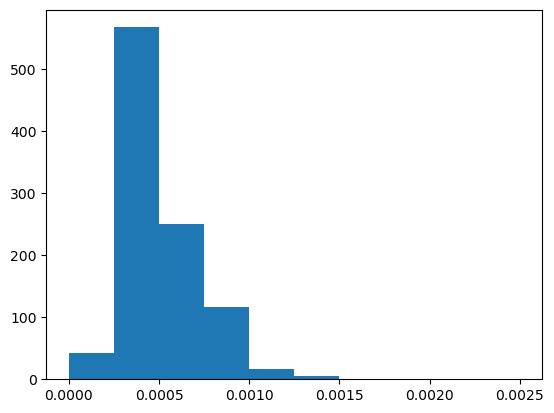

In [6]:
max_value = np.max(abs_650_700_mag)
bin_width = 0.00025
num_bins = int(np.ceil(max_value / bin_width))

# Create bin edges starting at 0
bin_edges = np.arange(0, (num_bins + 1) * bin_width, bin_width)

plt.hist(abs_650_700_mag,bins=bin_edges, )

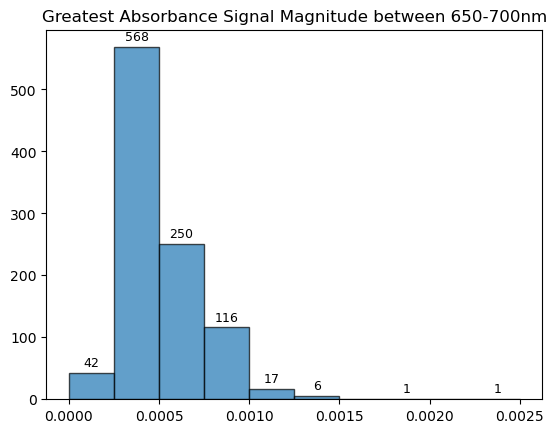

In [7]:
max_value = np.max(abs_650_700_mag)
bin_width = 0.00025
num_bins = int(np.ceil(max_value / bin_width))

# Create bin edges starting at 0
bin_edges = np.arange(0, (num_bins + 1) * bin_width, bin_width)

counts, bin_edges, patches = plt.hist(abs_650_700_mag, bins=bin_edges, edgecolor='black', alpha=0.7)

# Add count labels on top of each bin
for i, count in enumerate(counts):
    if count > 0:  # Only label bins that have data
        # Calculate the center of each bin for x-position
        bin_center = (bin_edges[i] + bin_edges[i+1]) / 2
        # Place text slightly above the bar
        plt.text(bin_center, count + max(counts)*0.01, str(int(count)), 
                ha='center', va='bottom', fontsize=9)

# plt.xlabel('Value')
# plt.ylabel('Frequency')
plt.title('Greatest Absorbance Signal Magnitude between 650-700nm')
plt.show()

In [8]:


wavelengths = np.array(dat['wavelength'])
abs_values = np.array(dat['abs'])

lambda1, lambda2 = 650, 700
mask = (wavelengths >= lambda1) & (wavelengths <= lambda2)
filtered_abs = abs_values[mask]

# Get the value with greatest magnitude (absolute value)
max_magnitude_value = filtered_abs[np.argmax(np.abs(filtered_abs))]
print(max_magnitude_value)
pd.DataFrame(dat)

-0.000364


wavelength       abs        ag
0           800  0.000307  0.007904
1           799  0.000262  0.006868
2           798  0.000392  0.009854
3           797  0.000308  0.007935
4           796  0.000443  0.011036
..          ...       ...       ...
546         254  0.098236  2.263201
547         253  0.099703  2.296994
548         252  0.101273  2.333143
549         251  0.102733  2.366777
550         250  0.104335  2.403665

[551 rows x 3 columns]

In [9]:
counts = df['cruise'].value_counts()
print(counts)

cruise
CV6                         189
CV7                         183
KR_2016                     161
CV4                         141
P16S                        130
CV5                         113
CV3                          60
Northern_Bering_Sea_2022     14
ECOA-3                       10
Name: count, dtype: int64


In [10]:
# with pd.option_context('display.max_rows', None):
#     display(df['cary_file'])

In [11]:
# if you choose to skip downloading all the raw .sb files, start here, uncomment the line and load in df

#df = pd.read_pickle('cary_ultrapath_paired_measurements.pkl')# I have all the .sb files downloaded and made this .pkl using the cell above
#df

##### We now have the paired cary and ultrapath data organized in a dataframe, and can begin to conduct merges.

We will save the merged products as new columns. See manuscript for in depth explanation

Merged product dataframe identifiers:
- val_th_0.4: value threshold merge values using the more conservative definition of $\mathrm{\lambda_{2}}$ where $\mathrm{a_{g, cary}}$ = 0.4 $\mathrm{m^{-1}}$
- val_th_0.2: value threshold merge values using the less conservative definition of $\mathrm{\lambda_{2}}$ where $\mathrm{a_{g, cary}}$ = 0.2 $\mathrm{m^{-1}}$
- pdiff: percent difference approach merge

before next step, need to set up 2 functions:
1) function to compute value threshold merge
2) function to compute percent difference merge

In [12]:
def vth_merge(carydat, wgdat, threshold):

    # function to compute value threshold merge approach, customize lambda2 threshold
    # for cary + ultrapath ag data
    # carydat and wgdat are (601,) length numpy.ndarrays
    # returns merged output (601 len)
    # also returns wlmin and wlmax (use for histograms)
    #ex usage: 
    # merge, wvmin, wvmax = custom_vth_merge(carydat, wgdat, 0.4)

    # this edition of function allows you to input the right threshold
    # use for less conservative comparison

    # for this single sample, combing cary and ultrapath measurements to 1 df with uniform index
    u = pd.DataFrame(wgdat.copy())[['wavelength', 'ag']].set_index('wavelength').sort_index().rename(columns={"ag": "ultra_ag"})
    new_index = np.arange(int(u.index.min()), int(u.index.max()) + 1)
    u = u.reindex(new_index, method='nearest')

    c = pd.DataFrame(carydat.copy())[['wavelength', 'ag']].set_index('wavelength').sort_index().rename(columns={"ag": "cary_ag"})
    new_index = np.arange(int(c.index.min()), int(c.index.max()) + 1)
    c = c.reindex(new_index, method='nearest')

    u.index = u.index.astype('float')
    c.index = c.index.astype('float')
    ucdf = pd.concat([u,c], axis = 1)
    ucdf.sort_index(inplace=True)

    wg_max_idx = int(np.nanargmax(ucdf['ultra_ag']))# returns index of max wg ag datapoint
    ucdf.iloc[0:wg_max_idx, ucdf.columns.get_loc('ultra_ag')] = np.nan  # mask all data before max, remove positive slope region
    cary_max_idx = int(np.nanargmax(ucdf['cary_ag']))# returns index of max cary ag datapoint
    ucdf.iloc[0:cary_max_idx, ucdf.columns.get_loc('cary_ag')] = np.nan  # mask all data before max, remove some scan errors

    try:
        wvmin = int(np.where(ucdf['ultra_ag']>1.3818)[0][-1])# returns last index before waveguide ag goes below 1.3818
    except:
        wvmin = int(wg_max_idx)
        
    # if wvmin<49:
    #     wvmin=49# extra condition to ensure lower bound is below the range of the cary data

    wvmax = np.where(ucdf['cary_ag']<threshold)[0][0]# returns first index where cary ag < 0.4
    
    #print('wvmin, wvmax',wvmin, wvmax)
    #return ucdf
    x_interp=np.arange(wvmin, wvmax+1)
    #x_interp
    # next up, set up and execute interpolation
    y_interp=np.linspace(0,1,len(x_interp))# linear interp from 0 to 1
    
    merged_part1 = ucdf.iloc[:wvmin, ucdf.columns.get_loc('cary_ag')]#begining part of merged spectra is 100% cary
    merged_part3 = ucdf.iloc[wvmax+1:, ucdf.columns.get_loc('ultra_ag')]# end part of merged spectra is 100% WG
    
    # # Merged part2: 
    wg_mid = ucdf.iloc[wvmin:wvmax+1, ucdf.columns.get_loc('ultra_ag')]
    cary_mid= ucdf.iloc[wvmin:wvmax+1, ucdf.columns.get_loc('cary_ag')]


    merged_part2=wg_mid*y_interp + cary_mid*(1-y_interp)
    
    #print(len(merged_part1), len(merged_part2), len(merged_part3))
    # #complete the merge, 2 append statements to combine the 3 parts
    merged_parts1_2=np.append(merged_part1,merged_part2)
    merged_complete=np.append(merged_parts1_2, merged_part3)
    ucdf['vth_merge_'+str(threshold)]=merged_complete

    return ucdf, wvmin, wvmax

In [13]:
# set function to conduct percent difference merge

def pdiff_merge(carydat, wgdat):
    # funciton to conduct percent difference merge

    # clean up the data and organize
    u = pd.DataFrame(wgdat.copy())[['wavelength', 'ag']].set_index('wavelength').sort_index().rename(columns={"ag": "ultra_ag"})
    new_index = np.arange(int(u.index.min()), int(u.index.max()) + 1)
    u = u.reindex(new_index, method='nearest')

    c = pd.DataFrame(carydat.copy())[['wavelength', 'ag']].set_index('wavelength').sort_index().rename(columns={"ag": "cary_ag"})
    new_index = np.arange(int(c.index.min()), int(c.index.max()) + 1)
    c = c.reindex(new_index, method='nearest')

    u.index = u.index.astype('float')
    c.index = c.index.astype('float')
    ucdf = pd.concat([u,c], axis = 1)
    ucdf.sort_index(inplace=True)

    wg_max_idx = int(np.nanargmax(ucdf['ultra_ag']))# returns index of max wg ag datapoint
    ucdf.iloc[0:wg_max_idx, ucdf.columns.get_loc('ultra_ag')] = np.nan  # mask all data before max, remove positive slope region
    cary_max_idx = int(np.nanargmax(ucdf['cary_ag']))# returns index of max cary ag datapoint
    ucdf.iloc[0:cary_max_idx, ucdf.columns.get_loc('cary_ag')] = np.nan  # mask all data before max, remove some scan errors

    ucdf['pdiff'] = ((ucdf['cary_ag']-ucdf['ultra_ag'])/ucdf['ultra_ag'])
    
    wvmax=int(np.where(ucdf.index == 348)[0][0])
    try:
        wvmin = np.where(abs(ucdf.iloc[:wvmax, ucdf.columns.get_loc('pdiff')]-ucdf.iloc[wvmax, ucdf.columns.get_loc('pdiff')])>0.05)[0][-1]
    except:
        wvmin= 50 #index of 250nm

    x_interp=np.arange(wvmin, wvmax+1)
    # next up, set up and execute interpolation
    y_interp=np.linspace(0,1,len(x_interp))# linear interp from 0 to 1
    
    merged_part1 = ucdf.iloc[:wvmin, ucdf.columns.get_loc('cary_ag')]#begining part of merged spectra is 100% cary
    merged_part3 = ucdf.iloc[wvmax+1:, ucdf.columns.get_loc('ultra_ag')]# end part of merged spectra is 100% WG
    
    # # Merged part2: 
    wg_mid = ucdf.iloc[wvmin:wvmax+1, ucdf.columns.get_loc('ultra_ag')]
    cary_mid= ucdf.iloc[wvmin:wvmax+1, ucdf.columns.get_loc('cary_ag')]


    merged_part2=wg_mid*y_interp + cary_mid*(1-y_interp)
    
    #print(len(merged_part1), len(merged_part2), len(merged_part3))
    # #complete the merge, 2 append statements to combine the 3 parts
    merged_parts1_2=np.append(merged_part1,merged_part2)
    merged_complete=np.append(merged_parts1_2, merged_part3)
    ucdf['pdiff_merge']=merged_complete

    return ucdf, wvmin, wvmax



In [14]:
# this cell, iterate through rows, compute value threshold merge for 0.4 and 0.2 limit, and pdiff merge. add relevant parameters as new columns
val_th_list_04=[]
val_th_wlmin_list_04=[]
val_th_wlmax_list_04=[]

val_th_list_02=[]
val_th_wlmin_list_02=[]
val_th_wlmax_list_02=[]

pdiff_list =[]
pdiff_wlmin =[]
pdiff_wlmax =[]

for row in df.iterrows():
    
    #print(row[1]['cary_file'],len(row[1]['Cary_data']['wavelength'].copy()),len(row[1]['Ultrapath_data']['wavelength'].copy()))
    val_th_merged, wvmin, wvmax = vth_merge(row[1]['Cary_data'].copy(), row[1]['Ultrapath_data'].copy(), 0.4)
    # #print('completed ' + str(row[0])) 
    val_th_list_04.append(val_th_merged)
    val_th_wlmin_list_04.append(wvmin)
    val_th_wlmax_list_04.append(wvmax)
    #print(len(row[1]['Cary_data'].copy()), len(row[1]['Ultrapath_data'].copy()))

    #repeat for less conservative bounds
    val_th_merged, wvmin, wvmax = vth_merge(row[1]['Cary_data'].copy(), row[1]['Ultrapath_data'].copy(), 0.2)
    val_th_list_02.append(val_th_merged)
    val_th_wlmin_list_02.append(wvmin)
    val_th_wlmax_list_02.append(wvmax)

    pdiff_merged, wvmin, wvmax = pdiff_merge(row[1]['Cary_data'].copy(), row[1]['Ultrapath_data'].copy())
    pdiff_list.append(pdiff_merged)
    pdiff_wlmin.append(wvmin)
    pdiff_wlmax.append(wvmax)

df['val_th_merge_0.4']=val_th_list_04
df['val_th_wlmin_list_0.4']=val_th_wlmin_list_04
df['val_th_wlmax_list_0.4']=val_th_wlmax_list_04

df['val_th_merge_0.2']=val_th_list_02
df['val_th_wlmin_list_0.2']=val_th_wlmin_list_02
df['val_th_wlmax_list_0.2']=val_th_wlmax_list_02

df['pdiff_merge'] = pdiff_list
df['pdiff_wlmin'] = pdiff_wlmin
df['pdiff_wlmax'] = pdiff_wlmax
#df

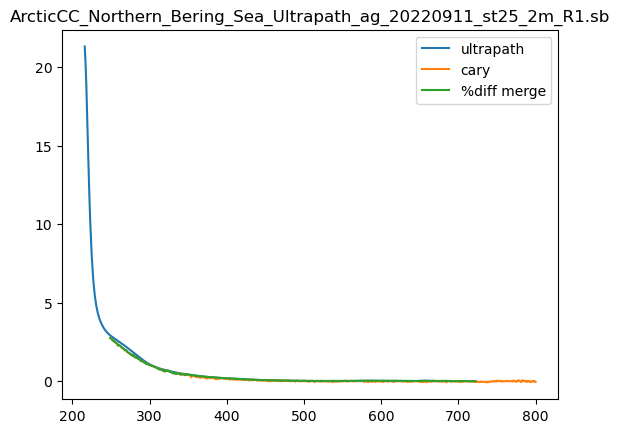

In [15]:
# choose a row index in df, then plot the cary, ultrapath, and vth_merged data

row = df.iloc[0]
#interesting indecies
# 830 - ecoa
# 0 - nbs

plt.plot(row['val_th_merge_0.4'].index,row['val_th_merge_0.4']['ultra_ag'], label='ultrapath' )
plt.plot(row['val_th_merge_0.4'].index,row['val_th_merge_0.4']['cary_ag'], label='cary' )
#plt.plot(row['val_th_merge_0.4'].index,row['val_th_merge_0.4']['vth_merge_0.4'], label='merged 0.4' )
#plt.plot(row['val_th_merge_0.2'].index,row['val_th_merge_0.2']['vth_merge_0.2'], label='merged 0.2' )
plt.plot(row['pdiff_merge'].index,row['pdiff_merge']['pdiff_merge'], label='%diff merge')
plt.title(row['ultrapath_file'])
plt.legend()
#row['val_th_merge_0.4']

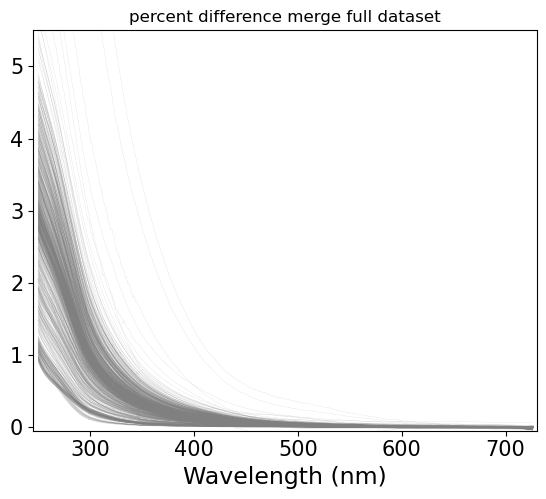

In [16]:
# summary plots: pdiff
fig, ax = plt.subplots(figsize=(6.5,5.2))
ax.set_xlabel('Wavelength (nm)', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim(-0.05,5.5)
ax.set_xlim(245, 730)
ax.set_title('percent difference merge full dataset')

for i in df['pdiff_merge'].values:
    ax.plot(i.index, i['pdiff_merge'], c='0.5', lw=0.06)

fig.patch.set_alpha(0.0)# to acheive transparent outer border, 
#plt.savefig(odir+'all_merged.png', dpi=300, bbox_inches='tight')

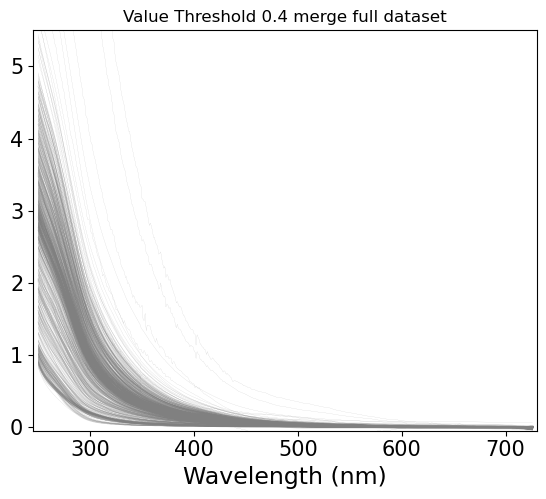

In [17]:
# summary plots: vth_merge 0.4
fig, ax = plt.subplots(figsize=(6.5,5.2))
ax.set_xlabel('Wavelength (nm)', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim(-0.05,5.5)
ax.set_xlim(245, 730)
ax.set_title('Value Threshold 0.4 merge full dataset')

for i in df['val_th_merge_0.4'].values:
    ax.plot(i.index, i['vth_merge_0.4'], c='0.5', lw=0.06)

fig.patch.set_alpha(0.0)# to acheive transparent outer border, 
#plt.savefig(odir+'all_merged.png', dpi=300, bbox_inches='tight')

#### Now, we have calculated all the merged cdom spectra for the analyses. Below, we conduct the analyses/produce the manuscript plots

At this point, we have constructed a pandas dataframe df, which contains our original ultrapath and waveguide spectra, in addition to the computed value threshold merge (using thresholds of both 0.4 and 0.2), and the computed percent difference merge. 

In [18]:
odir = 'publication_figures/'# set folder to write files to 
os.makedirs(odir, exist_ok=True)

In [19]:
# get lat and lon from seabass files:
lats = []
lons = []
for ultra_file in ultra_flist:
    ultra_sb = readSB(filename=ultra_dir+ultra_file, no_warn=True)
    lat = float(ultra_sb.headers['north_latitude'][:-5])
    lon = float(ultra_sb.headers['west_longitude'][:-5])
    if (lon < 60) & (lon>0):
        print(ultra_file)

    lats.append(lat)
    lons.append(lon)

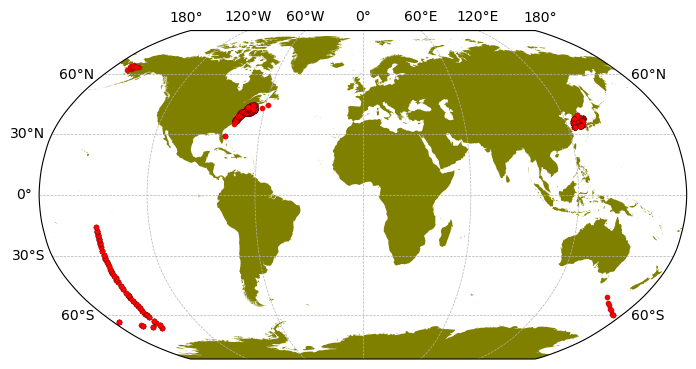

In [20]:
# fig 1: data map
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs

map_projection = cartopy.crs.Robinson()
cm = 1/2.54
fig, ax = plt.subplots(figsize=(18*cm,18*cm), nrows=1, subplot_kw={'projection': map_projection})
ax.set_global()
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m'), facecolor='olive',)#edgecolor='k', linewidth=0.25)

gl = ax.gridlines( draw_labels=True, linewidth=0.5,
             color='0.7', alpha=1,linestyle='--')

gl.bottom_labels = False; gl.top_labels = True; gl.right_labels = False; gl.left_labels = True

ax.scatter(lons, lats, s=15, c='r', zorder=2, alpha=1,
           transform = cartopy.crs.PlateCarree(), edgecolor='k', linewidth=0.1)

oname = 'summary_map_ag_merge.png'
plt.tight_layout()
plt.savefig(odir+oname, dpi=300)#, bbox_inches='tight')
#add map to other map with powerpoint

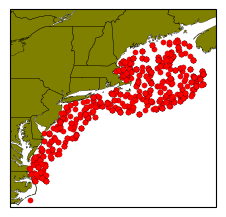

In [21]:
# map insert zoom on east coast of US

map_projection = cartopy.crs.PlateCarree()
fig, ax = plt.subplots(figsize=(6*cm,6*cm), nrows=1, subplot_kw={'projection': map_projection})
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m'), facecolor='olive',)#edgecolor='k', linewidth=0.25)
ax.add_feature(cartopy.feature.STATES, lw=0.2)
ext=[-77, -65, 34.5, 46]
ax.set_extent(ext, crs=map_projection)

ax.scatter(lons, lats, s=15, c='r', zorder=2, alpha=1,
           transform = cartopy.crs.PlateCarree(), edgecolor='k', linewidth=0.1)

oname = 'summary_map_ag_merge_subpanel.png'
fig.patch.set_alpha(0.0)# to acheive transparent outer border, 
plt.tight_layout()
plt.savefig(odir+oname, dpi=300)#, bbox_inches='tight')

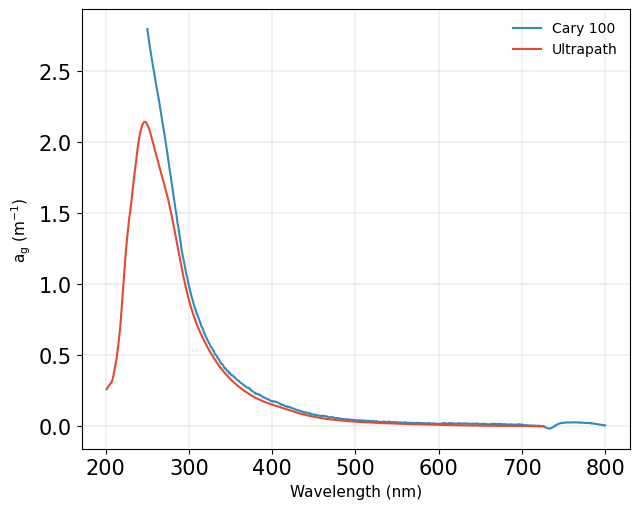

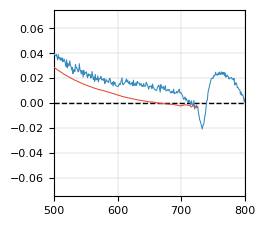

In [22]:
# Figure 1: Examples Cary vs ultrapath: Overall, plus zoom in on 
# UV and Red to show where each instrument is better
# since the UV is obvious to the naked eye, likely 
# won't use that zoomed-in subplot

#index 163, 167, 168 looks good for this

colors = ['#348ABD', '#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
x=168


#### full plot ####

fig, ax = plt.subplots(figsize=(6.5,5.2))
plt.plot(df.at[x, 'Cary_data']['wavelength'],df.at[x, 'Cary_data']['ag'], label='Cary 100' )
plt.plot(df.at[x, 'Ultrapath_data']['wavelength'],df.at[x, 'Ultrapath_data']['ag'], label='Ultrapath' )
ax.legend(fontsize=10, frameon=False)
ax.set_ylabel(r'$\mathregular{a_g}$ ($\mathregular{m^{-1}}$)', fontsize=11)
ax.set_xlabel('Wavelength (nm)', fontsize=11)
ax.grid(lw=0.25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.patch.set_alpha(0.0)# to acheive transparent outer border, 
plt.tight_layout()
#plt.savefig(odir+'fig_1_center.png', dpi=300)#, bbox_inches='tight')
# print(x)
# plt.show()

#### right edge zoom in ####

fig, ax = plt.subplots(figsize=(7*cm,6*cm))
plt.plot(df.at[x, 'Cary_data']['wavelength'],df.at[x, 'Cary_data']['ag'], lw=0.75, zorder=3 )
plt.plot(df.at[x, 'Ultrapath_data']['wavelength'],df.at[x, 'Ultrapath_data']['ag'], lw=0.75, zorder=3 )

#ax.set_ylabel('$\mathregular{a_g}$ ($\mathregular{m^{-1}}$)', fontsize=13)
#ax.set_xlabel('Wavelength (nm)', fontsize=13)\
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlim(500, 800)
ax.set_ylim(-0.075, 0.075)
ax.grid(lw=0.25, zorder=0)

plt.axhline(0, c='k', linestyle='--', zorder=2, lw=1)
#fig.patch.set_alpha(0.0)# to acheive transparent outer border, 
plt.tight_layout()
#plt.savefig(odir+'fig_1_right.png', dpi=300)#, bbox_inches='tight')
#plt.show()
#combine 2 plot pieces with ppt

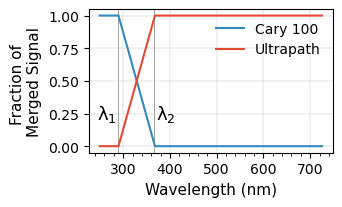

In [23]:
# here, make plot showing fraction of merged product signal coming
# from each instrument source across wavelengths

fig, ax = plt.subplots(figsize=(8.5*cm,5*cm))
#fig, ax = plt.subplots(figsize=(18*cm,9*cm))
wvl = np.arange(250,726)

wmi=290; wma=368
x_interp=np.arange(wmi, wma+1)
y_interp=np.linspace(0,1,len(x_interp))

wg_fracs=np.append(np.append(np.zeros(wmi-250), y_interp), np.ones(725-wma))
cary_fracs=1-wg_fracs

ax.plot(wvl, cary_fracs, label='Cary 100')
ax.plot(wvl, wg_fracs, label='Ultrapath')
ax.legend(fontsize=10, frameon=False)


ax.set_xlabel('Wavelength (nm)',fontsize=11)
ax.set_ylabel('Fraction of \nMerged Signal',fontsize=11)

ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(lw=0.25, zorder=0)
ax.axvline(wmi, c='0.5', zorder=0, lw=0.5, label=r'$\mathregular{a_g}$ Value Thresholds')
ax.axvline(wma-1, c='0.5', zorder=0, lw=0.5,)#, label='Cary ag < 0.4')
ax.annotate(r'$\mathrm{\lambda_{2}}$', [370, .21], fontsize=13)
ax.annotate(r'$\mathrm{\lambda_{1}}$', [243, .21], fontsize=13)

ax.set_xticks(ticks=[300,400,500,600,700])
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.tick_params(which='both', width=2)
# ax.tick_params(which='major', length=7)
ax.tick_params(which='minor')



#plt.title('$\mathregular{a_g}$ Value Threshold Merge Approach Signal Fractions', fontsize=15)

#fig.patch.set_alpha(0.0)# to acheive transparent outer border, 

# this is a useful paramter to adjust for single column figures!
plt.subplots_adjust(left=0.24, right=0.97, top=0.96, bottom=0.23, wspace=0.14)
#plt.tight_layout()
plt.savefig(odir+'signal_fraction.png', dpi=300)#, bbox_inches='tight')

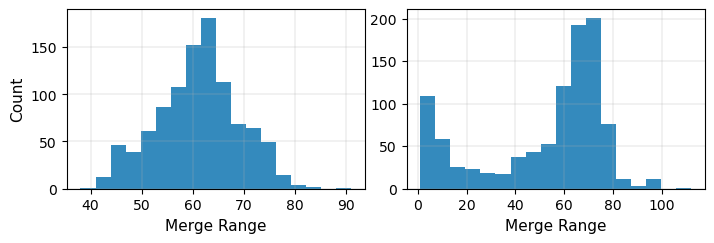

In [24]:

val_th_range = [a_i - b_i for a_i, b_i in zip(df['val_th_wlmax_list_0.4'].values, df['val_th_wlmin_list_0.4'].values)]
pdiff_range = [a_i - b_i for a_i, b_i in zip(df['pdiff_wlmax'].values, df['pdiff_wlmin'].values)]


fig, ax = plt.subplots(ncols=2, figsize=(18*cm,6*cm))
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=10)

ax[0].hist(val_th_range, bins=18)
ax[1].hist(pdiff_range, bins=18)
ax[0].grid(lw=0.25, zorder=0)
ax[1].grid(lw=0.25, zorder=0)

ax[0].set_xlabel('Merge Range',fontsize=11)
ax[0].set_ylabel('Count',fontsize=11)
ax[1].set_xlabel('Merge Range',fontsize=11)

#fig.patch.set_alpha(0.0)# to acheive transparent outer border, 
#plt.subplots_adjust(left=0.24, right=0.97, top=0.96, bottom=0.10, wspace=0.14)
plt.subplots_adjust(left=0.08, right=0.98, top=0.96, bottom=0.2, wspace=0.14)
#plt.savefig(odir+'histograms.png', dpi=300)#, bbox_inches='tight')

In [25]:
for r in df.iterrows():
    if ((r[1]['val_th_wlmax_list_0.4'] - r[1]['val_th_wlmin_list_0.4']) < 40):
        print(r[1]['ultrapath_file'])


CLiVEC_CV7_Ultrapath_ag_20120811_st40_29.54m_R1.sb


In [26]:
# subdf = df.where(df['cruise']=='P16S').dropna(how='all')
# subdf

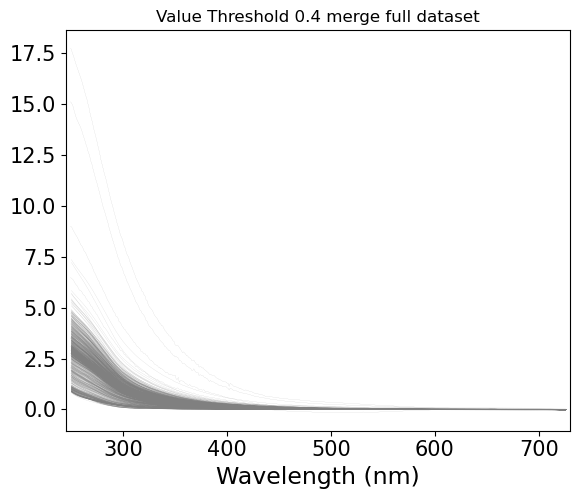

In [26]:
# summary plots: vth_merge 0.4
fig, ax = plt.subplots(figsize=(6.5,5.2))
ax.set_xlabel('Wavelength (nm)', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)
# ax.set_ylim(-0.05,5.5)
ax.set_xlim(245, 730)
ax.set_title('Value Threshold 0.4 merge full dataset')

for i in df['val_th_merge_0.4'].values:
    ax.plot(i.index, i['vth_merge_0.4'], c='0.5', lw=0.06)

fig.patch.set_alpha(0.0)# to acheive transparent outer border, 
#plt.savefig(odir+'all_merged.png', dpi=300, bbox_inches='tight')

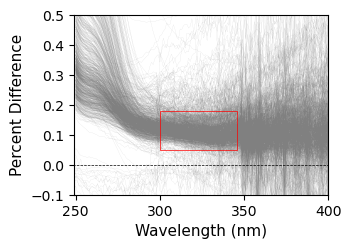

In [36]:
# all percent difference plots, illustrate stable reigion
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(8.5*cm,6*cm))

for r in df.iterrows():
    ax.plot(r[1]['pdiff_merge'].index, r[1]['pdiff_merge']['pdiff'], c='0.5', lw=0.04)

ax.set_ylim(-0.1,0.5)
ax.set_xlim(249, 400)
ax.set_xlabel('Wavelength (nm)',fontsize=11)
ax.set_ylabel('Percent Difference',fontsize=11)

ax.tick_params(axis='both', which='major', labelsize=10)
#ax.grid(lw=0.25, zorder=0)
ax.hlines(0,0,1000, colors='k', linestyle='--', lw=0.5)


# Add red box to highlight stable region
# Adjust these coordinates based on your stable region
stable_x_start = 300  # Start wavelength of stable region
stable_x_end = 346    # End wavelength of stable region
stable_y_start = 0.05 # Bottom y-coordinate of box
stable_y_end = 0.18   # Top y-coordinate of box
# Create rectangle
rect = patches.Rectangle((stable_x_start, stable_y_start), 
                        stable_x_end - stable_x_start,
                        stable_y_end - stable_y_start,
                        linewidth=0.5, 
                        edgecolor='red', 
                        facecolor='none',  # No fill color
                        zorder=10)

# Add rectangle to plot
ax.add_patch(rect)


plt.subplots_adjust(left=0.2, right=0.96, top=0.96, bottom=0.2, wspace=0.14)
plt.savefig(odir+'pdiffs.png', dpi=300)#, bbox_inches='tight')

In [29]:
# outdated code: abspectroscopy not reliable, use R package CDOM to do slope instead
# from numpy import inf as Inf
# # initialize function to compute cdom spectral slope
# def my_ag_slope(carydat,start_wl, end_wl, wl0):
#     # function to retrive cdom slope for a = a0*exp(-S*(x-wl0))+K
#     # x is wvl list
#     # y is ag value list
#     # start_wl and end_wl are the limits (integers) (e.g. S275:295 these are 275 and 295)
#     # wl0 is the reference wavelength

#     # first, make df
    
#     c = pd.DataFrame(carydat.copy())[['wavelength', 'ag']].set_index('wavelength').sort_index().rename(columns={"ag": "cary_ag"})
#     new_index = np.arange(int(c.index.min()), int(c.index.max()) + 1)
#     c = c.reindex(new_index, method='nearest')
#     c.index = c.index.astype('float')
#     df = c
#     df = df.reset_index()

#     #finally, crop to start_wl and end_wl
#     df=df.loc[(df['wavelength'] >= start_wl) & (df['wavelength'] <= end_wl)]



#     #return df
#     #print(df)
#     # next, calulate a0
#     a0 = df['cary_ag'].loc[df['wavelength']==wl0].values[0]
#     ia0=a0
#     #print('initial a0:', a0)
    
#     # good so far
#     y=df['cary_ag'].values
#     x=df['wavelength'].values
#     #print(x,y)

#     par_init_vals=[a0,0.02,0.01]# guesses for the initial values   # for [a0,S,K]
#     par_bounds= ([0, 0, -Inf], [max(y), 1, Inf])   

#     # scipy.optimize.curve_fit uses non-linear least squares to fit a 
#     # function, f, to data; bounds to constrain the optimization to the 
#     # region indicated by the lower and upper limit of the a0, S, K 
#     #parameters; maxfev specifies how many times the parameters for the 
#     #model that we are trying to fit are allowed to be altered
#     # adapted from: https://github.com/ClaCasc/AbspectroscoPY/blob/master/abs_fit_exponential.ipynb
    
#     popt,pcov=sp.optimize.curve_fit(lambda x,a0,S,K: a0*exp(-S*(x-wl0))+K,  x, y, p0 = par_init_vals, bounds = par_bounds, maxfev = 600)
#     #print('popt a0,S,K:',popt)                                   # the best-fit parameters.

#     a0=float(round(popt[0],4))                                           # round the parameter to three digits
#     S=float(round(popt[1],4))
#     K=float(round(popt[2],4)) 
#     #print('a0:',a0,'   S:', S, '   K:', K, '   wl0:', wl0, '   initial a0:',ia0 )
#     return a0,S,K 

In [30]:
my_ag_slope(r[1]['Cary_data'],275, 295, 275)

NameError: name 'my_ag_slope' is not defined

In [ ]:
# make list of all cary cdom spectral slopes:
s_list=[]

for row in df.iterrows():

    a0,S,K=my_ag_slope(row[1]['Cary_data'],275, 295, 285)
    s_list.append(S)


In [ ]:
# LOAD IN CDOM SLOPES CALCULATED IN R SCRIPT
# optional to skip this cell and the next one if you don't want to run R script

s_data = pd.read_csv('cary_s275_295.csv')


s_list = s_data['column_name'].values
s_list


array([0.0214944 , 0.0185722 , 0.02015833, ..., 0.03032463, 0.03005138,
       0.02849931], shape=(1001,))

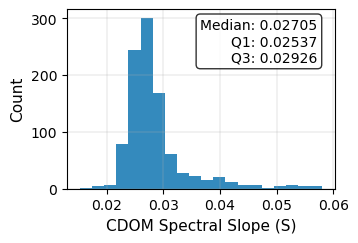

In [33]:
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots( figsize=(8.5*cm,6*cm))
ax.tick_params(axis='both', which='major', labelsize=10)
ax.hist(s_list, bins=20)
ax.grid(lw=0.25, zorder=0)
ax.set_xlabel('CDOM Spectral Slope (S)',fontsize=11)
ax.set_ylabel('Count',fontsize=11)

hist_mean = np.mean(s_list)
hist_median = np.median(s_list)
hist_q1 = np.percentile(s_list, 25)
hist_q3 = np.percentile(s_list, 75)

stats_text = (
    #f'Mean: {hist_mean:.5f}\n'
    f'Median: {hist_median:.5f}\n'
    f'Q1: {hist_q1:.5f}\n'
    f'Q3: {hist_q3:.5f}'
)

xmax = plt.xlim()[1]
ymax = plt.ylim()[1]

ax.text(xmax * 0.95, ymax * 0.95, stats_text,
         ha='right', va='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlim(0.013, xmax)

plt.subplots_adjust(left=0.18, right=0.98, top=0.96, bottom=0.2, wspace=0.14)
plt.savefig(odir+'slope_hist.png', dpi=300)#, bbox_inches='tight')


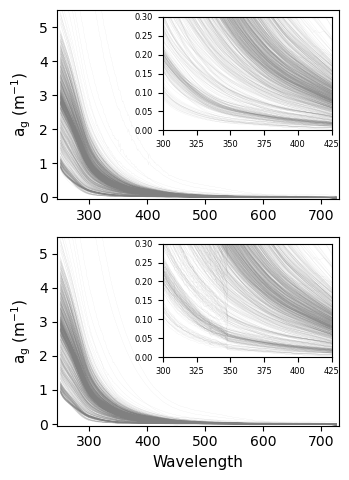

In [ ]:
# figure for merge results full dataset


cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(nrows=2,  figsize=(8.5*cm,12*cm))

ax[0].set_ylim(-0.05,5.5)
ax[0].set_xlim(245, 730)
for i in df['val_th_merge_0.4'].values:
    ax[0].plot(i.index, i['vth_merge_0.4'], c='0.5', lw=0.03)


ax[1].set_ylim(-0.05,5.5)
ax[1].set_xlim(245, 730)

for i in df['pdiff_merge'].values:
    ax[1].plot(i.index, i['pdiff_merge'], c='0.5', lw=0.03)

ax[1].set_xlabel('Wavelength',fontsize=11)
ax[0].set_ylabel(r'$\mathregular{a_g}$ ($\mathregular{m^{-1}}$)', fontsize=11)
ax[1].set_ylabel(r'$\mathregular{a_g}$ ($\mathregular{m^{-1}}$)', fontsize=11)

# Inset plot for ax1
inset1 = inset_axes(ax[0], width="60%", height="60%", loc='upper right')
inset1.set_ylim(0,0.3)
inset1.set_xlim(300, 425)
for i in df['val_th_merge_0.4'].values:
    inset1.plot(i.index, i['vth_merge_0.4'], c='0.5', lw=0.03)
inset1.tick_params(labelsize=6)

# Inset plot for ax2
inset2 = inset_axes(ax[1], width="60%", height="60%", loc='upper right')
inset2.set_ylim(0,0.3)
inset2.set_xlim(300, 425)
for i in df['pdiff_merge'].values:
    inset2.plot(i.index, i['pdiff_merge'], c='0.5', lw=0.03)
inset2.tick_params(labelsize=6)


plt.subplots_adjust(left=0.14, right=0.98, top=0.98, bottom=0.1, wspace=0.14)
plt.savefig(odir+'merge_full_dataset.png', dpi=300)#, bbox_inches='tight')


In [ ]:
df.keys()

Index(['ultrapath_file', 'cary_file', 'cruise', 'Ultrapath_data', 'Cary_data',
       'val_th_merge_0.4', 'val_th_wlmin_list_0.4', 'val_th_wlmax_list_0.4',
       'val_th_merge_0.2', 'val_th_wlmin_list_0.2', 'val_th_wlmax_list_0.2',
       'pdiff_merge', 'pdiff_wlmin', 'pdiff_wlmax'],
      dtype='object')

In [ ]:
df.at[25, 'cruise']

'P16S'

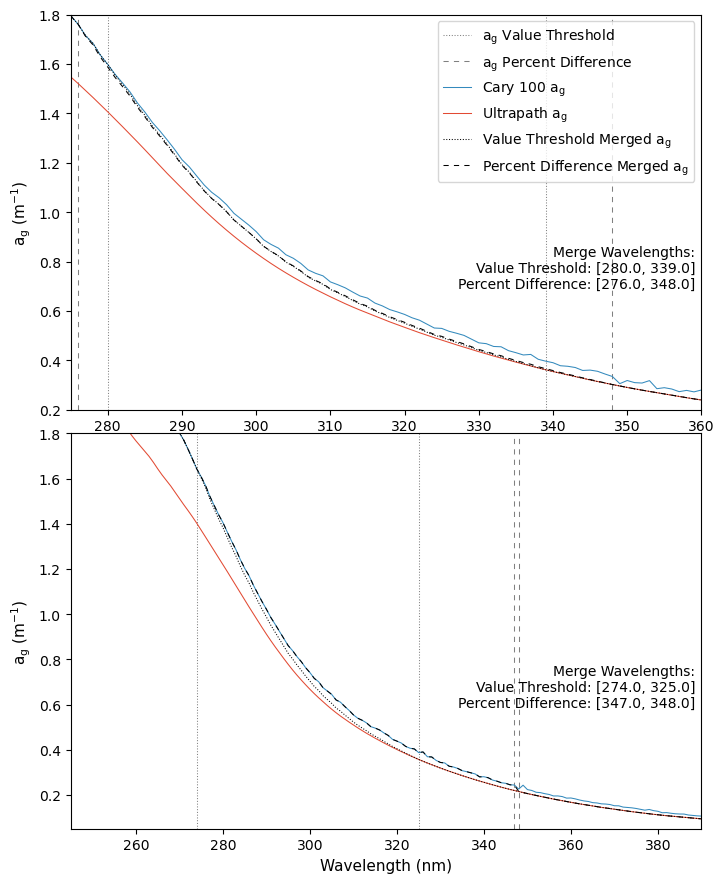

In [ ]:
# next plot, 2 ag spectra and merges comparison, oligotrophic vs coastal

# big 2 panel plot to compare merges for a good and a bad spectrum

idx1=277
idx2=271

# 878 close

# PLot 1 good indexes to issustrate my point: 168, 287, 277, 276
# plot 2 good indexes to illustrate: 271, 357, 392, 388, 393, 394, 


cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(nrows=2,  figsize=(18*cm,22*cm))


vtmin = float(df.at[idx1,'val_th_merge_0.4'].index[int(df.at[idx1, 'val_th_wlmin_list_0.4'].copy())])
vtmax = float(df.at[idx1,'val_th_merge_0.4'].index[int(df.at[idx1, 'val_th_wlmax_list_0.4'].copy())])
pdmin = float(df.at[idx1,'pdiff_merge'].index[int(df.at[idx1, 'pdiff_wlmin'].copy())])
pdmax = float(df.at[idx1,'pdiff_merge'].index[int(df.at[idx1, 'pdiff_wlmax'].copy())])

ax[0].axvline(int(vtmin), c='0.5', zorder=0, label=r'$\mathregular{a_g}$ Value Threshold', linestyle=':', lw=0.75)
ax[0].axvline(int(vtmax), c='0.5', zorder=0, linestyle=':', lw=0.75)#, label='Cary ag < 0.4')
ax[0].axvline(int(pdmin), c='0.5', zorder=0, linestyle=(0, (5, 5)), label=r'$\mathregular{a_g}$ Percent Difference', lw=0.75)
ax[0].axvline(int(pdmax), c='0.5', zorder=0, linestyle=(0, (5, 5)), lw=0.75)#, label='Cary ag < 0.4')

ax[0].plot(df.at[idx1, 'Cary_data']['wavelength'],df.at[idx1, 'Cary_data']['ag'], label=r'Cary 100 $\mathregular{a_g}$', lw=0.75)
ax[0].plot(df.at[idx1, 'Ultrapath_data']['wavelength'],df.at[idx1, 'Ultrapath_data']['ag'], label=r'Ultrapath $\mathregular{a_g}$', lw=0.75 )
ax[0].plot(df.at[idx1, 'val_th_merge_0.4']['vth_merge_0.4'], label=r'Value Threshold Merged $\mathregular{a_g}$', linestyle=':', c='k', lw=0.75)
ax[0].plot(df.at[idx1, 'pdiff_merge']['pdiff_merge'], label=r'Percent Difference Merged $\mathregular{a_g}$', linestyle=(0, (5, 5)), c='k', lw=0.75)



ax[0].set_ylabel(r'$\mathregular{a_g}$ ($\mathregular{m^{-1}}$)', fontsize=11)
ax[0].set_xlabel('Wavelength (nm)', fontsize=11)
ax[0].set_xlim(275, 360)
ax[0].set_ylim(0.2, 1.8)
ax[0].tick_params(axis='both', which='major', labelsize=10)

annot = ('Merge Wavelengths:' + 
         '\nValue Threshold: ['+str(vtmin)+', '+str(vtmax)+']'+
         '\nPercent Difference: ['+str(pdmin)+', '+str(pdmax)+']')

ax[0].annotate(annot,
                xy=(0.99, 0.3),
                horizontalalignment='right',
                verticalalignment='bottom',
                fontsize=10,
                xycoords='axes fraction')

ax[0].legend(fontsize=10, loc='upper right')#, frameon=False)



# bottom panel
vtmin = float(df.at[idx2,'val_th_merge_0.4'].index[int(df.at[idx2, 'val_th_wlmin_list_0.4'].copy())])
vtmax = float(df.at[idx2,'val_th_merge_0.4'].index[int(df.at[idx2, 'val_th_wlmax_list_0.4'].copy())])
pdmin = float(df.at[idx2,'pdiff_merge'].index[int(df.at[idx2, 'pdiff_wlmin'].copy())])
pdmax = float(df.at[idx2,'pdiff_merge'].index[int(df.at[idx2, 'pdiff_wlmax'].copy())])

ax[1].axvline(int(vtmin), c='0.5', zorder=0, label=r'$\mathregular{a_g}$ Value Threshold', linestyle=':', lw=0.75)
ax[1].axvline(int(vtmax), c='0.5', zorder=0, linestyle=':', lw=0.75)#, label='Cary ag < 0.4')
ax[1].axvline(int(pdmin), c='0.5', zorder=0, linestyle=(0, (5, 5)), label=r'$\mathregular{a_g}$ Percent Difference', lw=0.75)
ax[1].axvline(int(pdmax), c='0.5', zorder=0, linestyle=(0, (5, 5)), lw=0.75)#, label='Cary ag < 0.4')

ax[1].plot(df.at[idx2, 'Cary_data']['wavelength'],df.at[idx2, 'Cary_data']['ag'], label=r'Cary 100 $\mathregular{a_g}$', lw=0.75)
ax[1].plot(df.at[idx2, 'Ultrapath_data']['wavelength'],df.at[idx2, 'Ultrapath_data']['ag'], label=r'Ultrapath $\mathregular{a_g}$', lw=0.75 )
ax[1].plot(df.at[idx2, 'val_th_merge_0.4']['vth_merge_0.4'], label=r'Value Threshold Merged $\mathregular{a_g}$', linestyle=':', c='k', lw=0.75)
ax[1].plot(df.at[idx2, 'pdiff_merge']['pdiff_merge'], label=r'Percent Difference Merged $\mathregular{a_g}$', linestyle=(0, (5, 5)), c='k', lw=0.75)



ax[1].set_ylabel(r'$\mathregular{a_g}$ ($\mathregular{m^{-1}}$)', fontsize=11)
ax[1].set_xlabel('Wavelength (nm)', fontsize=11)
ax[1].set_xlim(245, 390)
ax[1].set_ylim(0.05, 1.8)
ax[1].tick_params(axis='both', which='major', labelsize=10)
annot = ('Merge Wavelengths:' + 
         '\nValue Threshold: ['+str(vtmin)+', '+str(vtmax)+']'+
         '\nPercent Difference: ['+str(pdmin)+', '+str(pdmax)+']')

ax[1].annotate(annot,
                xy=(0.99, 0.3),
                horizontalalignment='right',
                verticalalignment='bottom',
                fontsize=10,
                xycoords='axes fraction')
plt.subplots_adjust(left=0.09, right=0.98, top=.99, bottom=0.05, wspace=0, hspace=0.06)
plt.savefig(odir+'2_merge_compare_examples.png', dpi=300)#, bbox_inches='tight')






#### Final section of plots: Derivitives

In [ ]:
# Function to make spline, first, second derivitive

def get_splines(x,y):
    # determine spline interp, first, and second deriv of x,y
    # 1. first, logic to drop nan's
    mask = ~np.isnan(y)
    x = x[mask]# Apply the mask to both x and y
    y = y[mask]
    
    # 2. Perform cubic spline interpolation
    spline = CubicSpline(x, y)
    
    # 3. Compute the derivative of the spline (first derivative)
    spline_derivative_1 = spline.derivative()  # First derivative
    
    # 4. Compute the second derivative of the spline
    spline_derivative_2 = spline_derivative_1.derivative()  # Second derivative
    
    # 5. Define a fine grid of x values for plotting
    x_fine = np.linspace(min(x), max(x), 500)
    
    # 6. Evaluate the spline, its first derivative, and its second derivative on the fine grid
    y_spline = spline(x_fine)
    y_derivative_1 = spline_derivative_1(x_fine)
    y_derivative_2 = spline_derivative_2(x_fine)

    return y_spline, y_derivative_1, y_derivative_2, x_fine

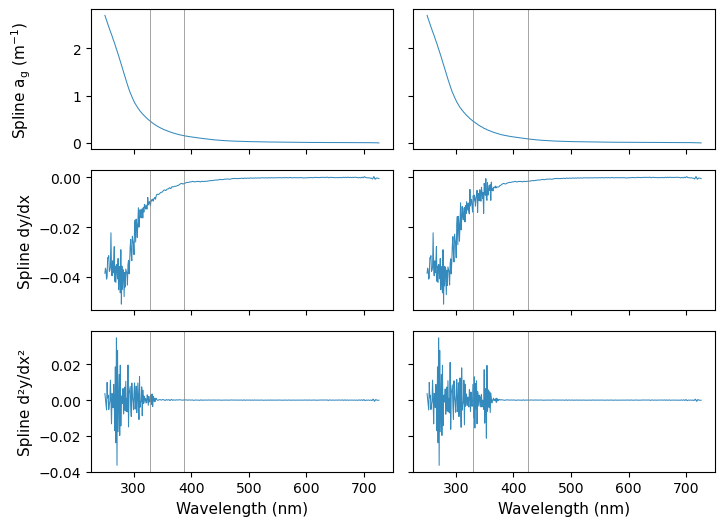

In [ ]:
idx2=277

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18*cm,13*cm))#max 18x22

vthdat=df.at[idx2, 'val_th_merge_0.4']['vth_merge_0.4'].copy()
wl = df.at[idx2, 'val_th_merge_0.4'].index
wl1_4=df.at[idx2,'val_th_wlmin_list_0.4'].copy()
wl2_4=df.at[idx2,'val_th_wlmax_list_0.4'].copy()

y0, y1, y2, xf = get_splines(wl,vthdat)

ax[0,0].plot(xf, y0, lw=0.75)
ax[1,0].plot(xf, y1, lw=0.75)
ax[2,0].plot(xf, y2, lw=0.75)

vthdat=df.at[idx2, 'val_th_merge_0.2']['vth_merge_0.2']
wl = df.at[idx2, 'val_th_merge_0.2'].index
wl1_2=df.at[idx2,'val_th_wlmin_list_0.2'].copy()
wl2_2=df.at[idx2,'val_th_wlmax_list_0.2'].copy()


y0, y1, y2, xf = get_splines(wl,vthdat)

ax[0,1].plot(xf, y0, lw=0.75)
ax[1,1].plot(xf, y1, lw=0.75)
ax[2,1].plot(xf, y2, lw=0.75)

ax[0,0].xaxis.set_tick_params(labelbottom=False)
ax[0,1].xaxis.set_tick_params(labelbottom=False)
ax[1,0].xaxis.set_tick_params(labelbottom=False)
ax[1,1].xaxis.set_tick_params(labelbottom=False)

ax[1,1].yaxis.set_tick_params(labelleft=False)
ax[2,1].yaxis.set_tick_params(labelleft=False)
ax[0,1].yaxis.set_tick_params(labelleft=False)

ax[2,0].set_xlabel('Wavelength (nm)', fontsize=11)
ax[2,1].set_xlabel('Wavelength (nm)', fontsize=11)

ax[0,0].set_ylabel(r'Spline $\mathregular{a_g}$ ($\mathregular{m^{-1}}$)', fontsize=11)
ax[1,0].set_ylabel('Spline dy/dx', fontsize=11)
ax[2,0].set_ylabel('Spline d²y/dx²', fontsize=11)

# left plots, vlines
ax[0,0].axvline(wvl[wl1_4],c='0.5',lw=0.5); ax[0,0].axvline(wvl[wl2_4],c='0.5',lw=0.5)
ax[1,0].axvline(wvl[wl1_4],c='0.5',lw=0.5); ax[1,0].axvline(wvl[wl2_4],c='0.5',lw=0.5)
ax[2,0].axvline(wvl[wl1_4],c='0.5',lw=0.5); ax[2,0].axvline(wvl[wl2_4],c='0.5',lw=0.5)
#right plots, vlines
ax[0,1].axvline(wvl[wl1_2],c='0.5',lw=0.5); ax[0,1].axvline(wvl[wl2_2],c='0.5',lw=0.5)
ax[1,1].axvline(wvl[wl1_2],c='0.5',lw=0.5); ax[1,1].axvline(wvl[wl2_2],c='0.5',lw=0.5)
ax[2,1].axvline(wvl[wl1_2],c='0.5',lw=0.5); ax[2,1].axvline(wvl[wl2_2],c='0.5',lw=0.5)

fig.align_ylabels(ax[:, 0])

plt.tight_layout()
plt.subplots_adjust(left=0.115, right=.995, top=.99, bottom=0.086)

plt.savefig(odir+'splines.png', dpi=300)#, bbox_inches='tight')


In [ ]:
# full dataset spline average, comparing 0.2 vs 0.4 threshold merges

# now, magnitude of 2nd deriv plot for full dataset

# new plot:
# For full dataset, use spline analysis to compute magnitude of 
# second derivitive under both limit conditions. 

# create 2 lists to store calculated 2nd deriv magnitudes
# iterate through df rows
# determine+save 2nd deriv magnitude for more conservative approach
# calculate vth merge for less conservative
# determine+save 2nd deriv magnitude for less conservative approach
# take average for both
# plot both, pretty plot


second_deriv_list_0_4=[]
second_deriv_list_0_2=[]


for i in df['val_th_merge_0.4'].values:
    x = i.index
    y = i['vth_merge_0.4']
    # 1. first, logic to drop nan's
    mask = ~np.isnan(y)
    # print('mask',len(mask))
    # print('x', len(x))
    # print('y', len(y))
    x = x[mask]# Apply the mask to both x and y
    y = y[mask]
    # 2. Perform cubic spline interpolation
    spline = CubicSpline(x, y)
    # 3. Compute the derivative of the spline (first derivative)
    spline_derivative_1 = spline.derivative()  # First derivative
    # 4. Compute the second derivative of the spline
    spline_derivative_2 = spline_derivative_1.derivative()

    # 5. Define a fine grid of x values for plotting
    x_fine = np.linspace(min(x), max(x), 500)
    
    # 6. Evaluate the spline, its first derivative, and its second derivative on the fine grid
    y_spline = spline(x_fine)
    y_derivative_1 = spline_derivative_1(x_fine)
    y_derivative_2 = spline_derivative_2(x_fine)
    #print(len(y_spline))#all are the same, makes my life easier
    #print(type(y_derivative_2))
    #plt.plot(x_fine, y_spline)
    second_deriv_list_0_4.append(list(y_derivative_2))

for i in df['val_th_merge_0.2'].values:
    x = i.index
    y = i['vth_merge_0.2']

    #Now, within the same loop, repeat the analysis for the less conservatiive merge:

    # 1. first, logic to drop nan's
    mask = ~np.isnan(y)
    # print('mask',len(mask))
    # print('x', len(x))
    # print('y', len(y))
    x = x[mask]# Apply the mask to both x and y
    y = y[mask]
    # 2. Perform cubic spline interpolation
    spline = CubicSpline(x, y)
    # 3. Compute the derivative of the spline (first derivative)
    spline_derivative_1 = spline.derivative()  # First derivative
    # 4. Compute the second derivative of the spline
    spline_derivative_2 = spline_derivative_1.derivative()

    # 5. Define a fine grid of x values for plotting
    x_fine = np.linspace(min(x), max(x), 500)
    
    # 6. Evaluate the spline, its first derivative, and its second derivative on the fine grid
    y_spline = spline(x_fine)
    y_derivative_1 = spline_derivative_1(x_fine)
    y_derivative_2 = spline_derivative_2(x_fine)
    #print(len(y_spline))#all are the same, makes my life easier
    #print(type(y_derivative_2))
    #plt.plot(x_fine, y_spline)
    second_deriv_list_0_2.append(list(y_derivative_2))


In [ ]:
# calculate averages of 2nd derivs
a = np.array(second_deriv_list_0_4)
b=np.mean(a, axis=0)

a2 = np.array(second_deriv_list_0_2)
b2=np.mean(a2, axis=0)

b3 = abs(b2) -abs(b)
neg=0
pos=0
for i in b3:
    if i>0:
        pos=pos+1
    elif i<0:
        neg=neg+1
print(pos, neg)


201 103


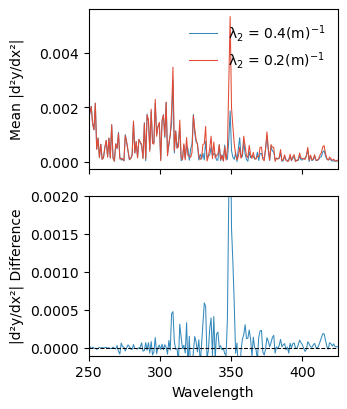

In [ ]:
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(nrows=2,  figsize=(8.5*cm,10*cm))

ax[0].plot(x_fine, abs(b), label=r'$\mathrm{\lambda_{2}}$ = $\mathrm{0.4 (m)^{-1}}$', lw=0.75)
ax[0].plot(x_fine, abs(b2), label=r'$\mathrm{\lambda_{2}}$ = $\mathrm{0.2 (m)^{-1}}$', lw=0.75)
ax[0].set_xlim(250, 425)
#ax[0].set_xlabel('Wavelength')
ax[0].set_ylabel('Mean |d²y/dx²|')
#plt.ylim(0, 0.002)
ax[0].legend(fontsize=10, frameon=False, loc='upper right')

ax[1].plot(x_fine, b3, label=r'($\mathrm{\lambda_{2}}$ = $\mathrm{0.2 (m)^{-1}}$) - ($\mathrm{\lambda_{2}}$ = $\mathrm{0.4 (m)^{-1}}$)', lw=0.75)
ax[1].set_xlim(250, 425)
ax[1].set_ylim(-0.0001, 0.002)
ax[1].set_xlabel('Wavelength')
ax[1].set_ylabel('|d²y/dx²| Difference')
ax[1].axhline(0, c='k', linestyle='--', lw=0.75)
#ax[1].legend()


ax[0].xaxis.set_tick_params(labelbottom=False)

fig.align_ylabels(ax[:])
plt.tight_layout()

plt.subplots_adjust(left=0.25, right=0.995, top=0.995, bottom=0.115)
plt.savefig(odir+'2nd_deriv_mag', dpi=300)

In [ ]:
print('a')

a
